In [1]:
from shared.preface import *
import shared.functions as fct

## Ch. 0: Preliminary Investigations.

### 2D grid, center coord. pairs.

In [2]:
def grid_2D(l, s):

    # 2D spatial grid, discretized.
    eps = s/10
    x, y = np.mgrid[-l:l+eps:s, -l:l+eps:s]

    # [x y] edge coordinate pairs of above grid.
    xy = np.mgrid[-l:l+eps:s, -l:l+eps:s].reshape(2,-1).T

    # Create center coord.-pairs.
    x_centers = (x[1:,:] + x[:-1,:])/2.
    y_centers = (y[:,1:] + y[:,:-1])/2.
    centers = np.array([x_centers[:,:-1], y_centers[:-1,:]])
    cent_coordPairs2D = centers.reshape(2,-1).T
    print('All coord. pairs 2D:\n', cent_coordPairs2D)
    # print('Coord pairs 2D shape:', cent_coordPairs2D.shape)

    return cent_coordPairs2D

limit_coarse, space_coarse = 1.5, 1.
cent_coordPairs2D = grid_2D(limit_coarse, space_coarse)

# Delete middle square.
cent_coordPairs2D = np.delete(cent_coordPairs2D, 4, axis=0)

# Create finegrained square.
limit_fine, space_fine = limit_coarse/2., space_coarse/2.
cent_coordPairs2D_fine = grid_2D(limit_fine, space_fine)

# Insert finegrained square.

All coord. pairs 2D:
 [[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]
All coord. pairs 2D:
 [[-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]]


### 3D grid, center coord. pairs.

In [3]:
# 3D spatial grid, discretized.
x, y, z = np.mgrid[-1:1.1:1., -1:1.1:1., -1:1.1:1.]
# print(x[0,...], x.shape)

x_centers = (x[1:,...] + x[:-1,...])/2.
# print(x_centers, x_centers.shape)

y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
# print(y_centers, y_centers.shape)

z_centers = (z[...,1:] + z[...,:-1])/2.
# print(z_centers, z_centers.shape)


# Create center coord.-pairs., truncate redundant points.
centers3D = np.array([
    x_centers[:,:-1,:-1], 
    y_centers[:-1,:,:-1], 
    z_centers[:-1,:-1,:]
])
# print(centers3D, centers3D.shape)

cent_coordPairs3D = centers3D.reshape(3,-1).T 
print(cent_coordPairs3D, cent_coordPairs3D.shape)

[[-0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5]
 [-0.5  0.5 -0.5]
 [-0.5  0.5  0.5]
 [ 0.5 -0.5 -0.5]
 [ 0.5 -0.5  0.5]
 [ 0.5  0.5 -0.5]
 [ 0.5  0.5  0.5]] (8, 3)


## Ch. 1: Milky Way-type halo and simple grid.

### 3D plot of the DM particles.

126187


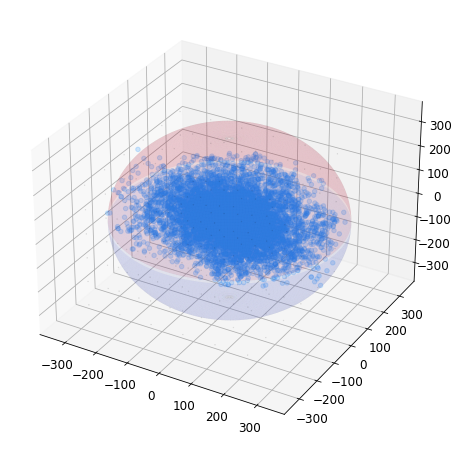

In [4]:
# Read DM particles.
fct.read_DM_positions_randomHalo(which_halos='halos', mass_select=12)

# Build grid around Milky Way.
MW_grid = fct.grid_3D(GRID_L, GRID_S) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Read in DM particle positions.
DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')
print(f'{len(DM_pos)}')
x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.2, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = MW_grid[:,0], MW_grid[:,1], MW_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.1)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

plt.show()

### Calculate gravity in each cell.

In [5]:
DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')

### Testing 1 cell with coords. at earth.
cell_id = 0
cell1 = np.array([8.5, 0, 0])*kpc

cell_vector = fct.cell_gravity(cell1, DM_pos, GRAV_RANGE, DM_SIM_MASS)
cell_vector /= (kpc/s**2)  
print(cell_vector)
print(np.sqrt(np.sum(cell_vector**2)))

#! this should be around same order of magnitude as in spher. symmetric setup.

[-1.47629727e-29 -1.71292523e-32  4.08050370e-31]
1.4768620802502691e-29


## Ch. 2: Broadcasting for cell_gravity.

In [25]:
def cell_gravity(cell_coords, DM_coords, grav_range, m_DM):
    
    # Center all DM positions w.r.t. cell center.
    DM_cc = DM_coords*kpc - cell_coords
    # print('DM_cc:', DM_cc.shape)

    # Calculate distances of DM to cc.
    DM_dist = np.sqrt(np.sum(DM_cc**2, axis=2))
    # print('DC_dist:', DM_dist.shape)

    # Ascending order indices.
    ind = DM_dist.argsort(axis=1)
    # print('ind:', ind.shape)
    ind_3D = np.expand_dims(ind, axis=2)
    # print('ind_3D:', ind_3D.shape)
    ind_3D = np.repeat(ind_3D, 3, axis=2)
    # print('ind_3D:', ind_3D.shape)

    # Sort DM positions according to dist.
    
    DM_pos_sort = np.take_along_axis(DM_cc, ind_3D, axis=1)
    # print('DM_pos_sort:', DM_pos_sort.shape)
    # print('DM_pos_sort:', DM_pos_sort[0,:3,:], DM_pos_sort[1,:3,:])
    DM_dist_sort = np.take_along_axis(DM_dist, ind, axis=1)
    # print('DM_dist_sort:', DM_dist_sort.shape)
    # print('DM_dist_sort:', DM_dist_sort[0,:5], DM_dist_sort[1,:5])

    # Truncate DM positions depending on distance to cc.
    if grav_range is None:
        DM_pos_inRange = DM_pos_sort
        DM_dist_inRange = DM_dist_sort
    else:
        DM_pos_inRange = DM_pos_sort[DM_dist_sort <= grav_range]
        DM_dist_inRange = DM_dist_sort[DM_dist_sort <= grav_range]

    # Adjust the distances array to make it compatible with DM positions array.
    DM_dist_inRange_sync = DM_dist_inRange.reshape(len(DM_dist_inRange),1)
    DM_dist_inRange_rep = np.repeat(DM_dist_inRange_sync, 3, axis=1)

    # print(f'{len(DM_pos_trunc)} DM particles inside range')

    ### Calculate superposition gravity.
    pre = G*m_DM
    quotient = (cell_coords-DM_pos_inRange)/(DM_dist_inRange_rep**3)
    derivative = pre*np.sum(quotient, axis=0)

    #NOTE: Minus sign, s.t. velocity changes correctly (see notes).
    return np.asarray(-derivative, dtype=np.float64)


fct.read_DM_positions_randomHalo(which_halos='halos', mass_select=12)
DM = np.load('sim_data/DM_positions_halos_M12.npy')[1::100]
grid = fct.grid_3D(GRID_L, GRID_S)

# print(DM.shape)
# print(grid.shape)

grid = np.expand_dims(grid, axis=1)
# print(grid.shape)

DM = np.expand_dims(DM, axis=0)
# print(DM.shape)

DM = np.repeat(DM, len(grid), axis=0)
# print(DM.shape)

# diff = DM - grid
# print(diff.shape, (diff.nbytes)/1e6)

dPsi_grid = cell_gravity(grid, DM, GRAV_RANGE, DM_SIM_MASS)

ValueError: cannot reshape array of size 272592 into shape (216,1)

In [7]:
DM = 2.*np.random.randint(0,10, (5,3))
grid = np.random.randint(0,10, (2,3))
# print(DM.shape)
# print(grid.shape)

grid = np.expand_dims(grid, axis=1)
# print(grid.shape)

DM = np.expand_dims(DM, axis=0)
# print(DM.shape)

DM = np.repeat(DM, len(grid), axis=0)
print(DM.shape)

diff = DM - grid
# print(diff.shape)

DM_dist = np.sqrt(np.sum(DM**2, axis=2))

# Ascending order indices.
ind = DM_dist.argsort(axis=1)
print(ind.shape, ind)
# ind = np.expand_dims(ind, axis=2)
# ind = np.repeat(ind, 3, axis=2)
# print(ind.shape)
# print(ind)

DM_re = DM[:,ind[0],:]
print(DM_re.shape)

(2, 5, 3)
(2, 5) [[0 2 3 4 1]
 [0 2 3 4 1]]
(2, 5, 3)


In [ ]:
a = np.random.randn(3, 3)
print(a)
print(np.argsort(a))

print(np.array(list(map(lambda x, y: y[x], np.argsort(a), a))))

## Ch. 3: Better derivative grid structure. 